# Sampling from the *Hy-MMSBM* generative model

## Overview

- Sample synthetic hypergraphs from the Hy-MMSBM generative model.
- Explore parameters and inspect the resulting community structure.


## Setup


In [ ]:
import matplotlib as mpl

mpl.rcParams.update({
    "figure.figsize": (6, 4),
    "figure.dpi": 120,
    "savefig.dpi": 150,
})


In [1]:
import sys
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
from hypergraphx.communities.hy_mmsbm.model import HyMMSBM
from hypergraphx.core.hypergraph import Hypergraph
from hypergraphx.generation.hy_mmsbm_sampling import HyMMSBMSampler
from hypergraphx.linalg.linalg import binary_incidence_matrix

np.random.seed(123)

## Vanilla sampling from the generative model

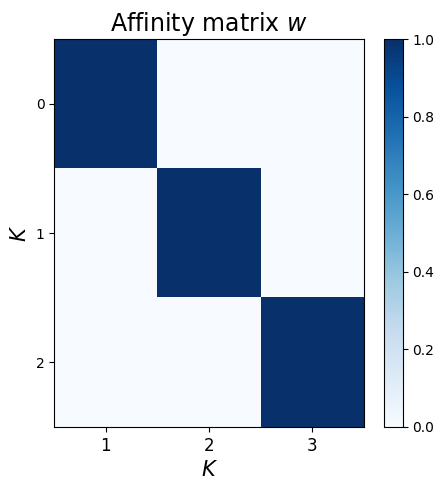

In [2]:
# Diagonal affinity matrix, which results in an assortative structure
w = np.eye(3)

plt.matshow(w, aspect='auto', cmap='Blues')
plt.gcf().set_size_inches(5, 5)
plt.title(r'Affinity matrix $w$', fontsize=17)
plt.xlabel(r'$K$', fontsize=15)
plt.ylabel(r'$K$', fontsize=15)
plt.xticks(ticks=[0,1,2], labels=[1,2,3], size=12)
plt.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)
plt.colorbar()
plt.show()

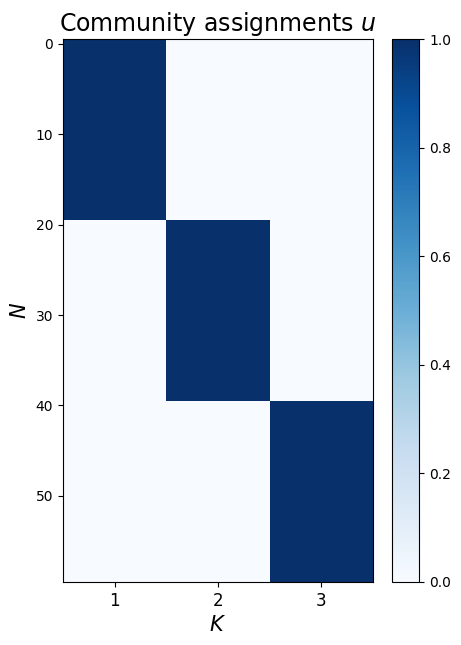

In [3]:
# Community assignments
u = np.zeros((60, 3))
u[:20, 0] = 1
u[20:40, 1] = 1
u[40:, 2] = 1

plt.matshow(u, aspect='auto', cmap='Blues')
plt.gcf().set_size_inches(5, 7)
plt.title(r'Community assignments $u$', fontsize=17)
plt.xlabel(r'$K$', fontsize=15)
plt.ylabel(r'$N$', fontsize=15)
plt.xticks(ticks=[0,1,2], labels=[1,2,3], size=12)
plt.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)
plt.colorbar()
plt.show()

In [4]:
sampler = HyMMSBMSampler(
    w=w, 
    u=u,
    max_hye_size=10
)
sample_generator = sampler.sample()

In [5]:
%%time

for i in range(10):
    print("Getting sample number:", i)
    new_sample = next(sample_generator)

# Get some more samples later in the code
print("Getting another couple of samples...")
_ = next(sample_generator)
_ = next(sample_generator)

Getting sample number: 0
Getting sample number: 1
Getting sample number: 2
Getting sample number: 3
Getting sample number: 4
Getting sample number: 5
Getting sample number: 6
Getting sample number: 7
Getting sample number: 8
Getting sample number: 9
Getting another couple of samples...
CPU times: user 7.26 s, sys: 202 ms, total: 7.47 s
Wall time: 7.85 s


In [6]:
sample = next(sample_generator)
print(f"Extracted sample with N={sample.num_nodes()} nodes and |E|={sample.num_edges()} hyperedges.")

Extracted sample with N=60 nodes and |E|=851 hyperedges.


Notice, however, that all the samples generated from the same call of `HyMMSBMSampler.sample` will have the same degree and size sequence. To have a completely new sample, a new call to the method is needed.

## Conditioning the sampling with additional inputs

#### 1. Providing input sequences

In [7]:
w = np.eye(3)
u = np.zeros((200, 3))
u[:66, 0] = 1
u[66:133, 1] = 1
u[133:, 2] = 1

deg_seq = np.random.randint(low=1, high=5, size=200)

sampler = HyMMSBMSampler(
    w=w, 
    u=u,
    max_hye_size=4,
)
sample_generator = sampler.sample(deg_seq=deg_seq)
sample = next(sample_generator)

print(
    "Does the sample have same degree sequence as the input one?", 
    np.all(binary_incidence_matrix(sample).sum(axis=1) == deg_seq)
)

Does the sample have same degree sequence as the input one? False


Notice that, due to the approximations in the MCMC procedure, sometimes the degree sequence in the samples could very slightly deviate from the input one. 

Similarly, to provide the dimension sequence:

In [8]:
# 10 hyperedges of size 3, 7 hyperedges of size 4, etc...
dim_seq = {
    3: 10,
    4: 7,
    7: 5,
    9: 5,
    12: 3,
}

sampler = HyMMSBMSampler(
    w=w, 
    u=u,
    max_hye_size=4,
)
sample_generator = sampler.sample(dim_seq=dim_seq)
sample = next(sample_generator)

print(
    "Does the sample have same dimension sequence as the input one?", 
    dict(Counter(len(hye) for hye in sample)) == dim_seq
)

Does the sample have same dimension sequence as the input one? False


#### 2. Providing an input hypergraph

## TODO CHANGE DATASET LOADING HERE

In [9]:
def line_to_hyperedge(line):
    hye = line
    hye = line.strip("\n")
    hye = [int(node) for node in line.split(" ")]
    return hye

# Load Justice dataset.
with open("./_example_data/justice_data/hyperedges.txt", "r") as hye_file:
    with open("./_example_data/justice_data/weights.txt", "r") as weight_file:
        justice = Hypergraph([
            line_to_hyperedge(hye)
            for hye, weight in zip(hye_file.readlines(), weight_file.readlines())
        ])

N = justice.num_nodes()
K = 2  # arbitrarily chosen

w = np.eye(K)
# Random hard community assignments.
u = np.zeros((N, K))
u[np.arange(N), np.random.randint(0, K, size=N)] = 1  

In [10]:
model = HyMMSBMSampler(
    u=u, 
    w=w,
)
sample_generator = model.sample(initial_hyg=justice)
_ = next(sample_generator)

## Pre-adjusting the expected statistics

In [11]:
# Diagonal affinity matrix
w = np.eye(3)

# Community assignments
u = np.zeros((60, 3))
u[:20, 0] = 1
u[20:40, 1] = 1
u[40:, 2] = 1

max_hye_size=10

model = HyMMSBM(
    u=u, 
    w=w,
    max_hye_size=max_hye_size
)
orig_deg = model.expected_degree()
orig_deg

53.75039682539682

To obtain, for example, an expected degree of 100, one can simply rescale $w$ or $u$.

In [12]:
new_deg = 100

rescaled_w = w / orig_deg * new_deg
new_w_model = model = HyMMSBM(
    u=u, 
    w=rescaled_w,
    max_hye_size=max_hye_size
)
print("Expected degree when rescaling w:", new_w_model.expected_degree())

rescaled_u = u / np.sqrt(orig_deg) * np.sqrt(new_deg)
new_u_model = HyMMSBM(
    u=rescaled_u, 
    w=w,
    max_hye_size=max_hye_size
)
print("Expected degree when rescaling u:", new_u_model.expected_degree())

Expected degree when rescaling w: 100.0
Expected degree when rescaling u: 100.00000000000001
